In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import StandardScaler


# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_colwidth', None)

In [3]:
data_folder_path = "../data"  # Update this path accordingly
df = pd.DataFrame()

file_list = [file for file in os.listdir(data_folder_path) if not file.startswith('60')]

for file_name in file_list:
    root_file_path = os.path.join(data_folder_path, file_name)
    csv_df = pd.read_csv(root_file_path)
    csv_df['memory_usage'] = file_name.split('.')[0]
    df = pd.concat([df, csv_df])

In [4]:
df

,Unnamed: 0,cpu_0_freq_cur,cpu_0_freq_max,cpu_0_freq_min,cpu_0_governor,cpu_0_idle,cpu_0_idle_state_WFI,cpu_0_idle_state_c7,cpu_0_info_freq_cur,cpu_0_info_freq_max,...,processes_2_0,processes_2_1,processes_2_2,processes_2_3,processes_2_4,processes_2_5,processes_2_6,processes_2_7,processes_2_8,processes_2_9
0,0,307200,1479000,102000,schedutil,85.858586,1,1,307200,1479000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1479000,1479000,102000,schedutil,78.394223,1,1,1479000,1479000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,204000,1479000,102000,schedutil,64.000000,1,1,403200,1479000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,307200,1479000,102000,schedutil,82.828283,1,1,307200,1479000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,204000,1479000,102000,schedutil,87.000000,1,1,307200,1479000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1942,1942,1479000,1479000,1479000,schedutil,94.949495,1,1,1479000,1479000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1943,1943,1479000,1479000,1479000,schedutil,97.938144,1,1,1479000,1479000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1944,1944,1479000,1479000,1479000,schedutil,95.876289,1,1,1479000,1479000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1945,1945,1479000,1479000,1479000,schedutil,95.000000,1,1,1479000,1479000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df.isnull().sum()

Unnamed: 0            0
cpu_0_freq_cur        0
cpu_0_freq_max        0
cpu_0_freq_min        0
cpu_0_governor        0
                  ...  
processes_2_5     17179
processes_2_6     17179
processes_2_7     17179
processes_2_8     17179
processes_2_9     17179
Length: 150, dtype: int64

### Consider only the rows where at least one process running is gpu_burn

In [6]:
df.groupby("memory_usage")["fan_tegrapwm_speed"].diff()

0             NaN
1      -28.235294
2        0.000000
3        0.000000
4        0.000000
          ...    
1942     0.000000
1943     0.000000
1944     0.000000
1945     0.000000
1946     1.568627
Name: fan_tegrapwm_speed, Length: 17184, dtype: float64

In [7]:
process_columns = df.filter(like="process_")
filtered_df = df[process_columns.eq("gpu_burn").any(axis=1)]
df["time"] = df.groupby("memory_usage").cumcount()

### Fan speed

<Axes: xlabel='time', ylabel='fan_speed_diff'>

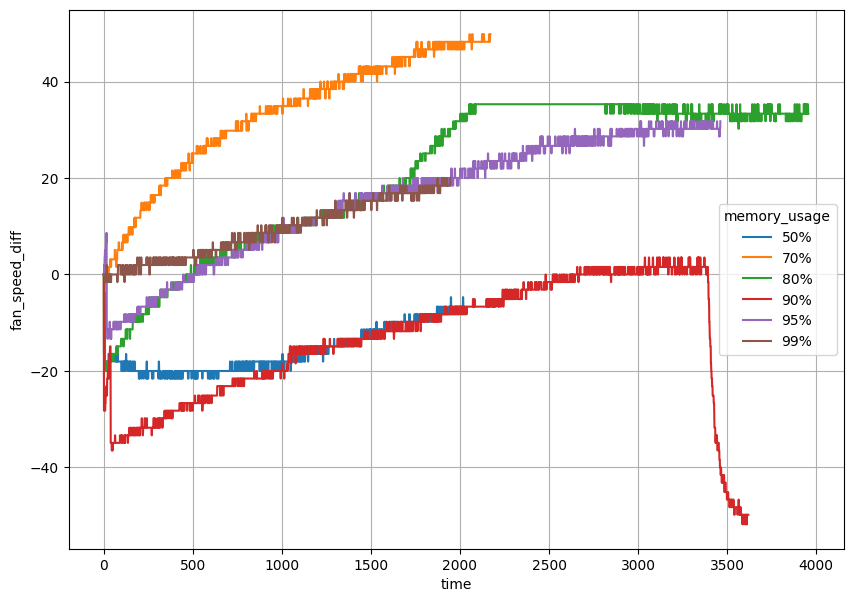

In [39]:
df["fan_speed_diff"] = df["fan_tegrapwm_speed"] - df.groupby("memory_usage")["fan_tegrapwm_speed"].transform("first")
fig, ax = plt.subplots(1,1,figsize=(10,7))
hue_order = ['50%', '70%', '80%', '90%', '95%', '99%']
ax.grid()
sns.lineplot(data=df, x='time', y='fan_speed_diff', hue='memory_usage', ax = ax, hue_order=hue_order)

<Axes: xlabel='time', ylabel='GPU_temp'>

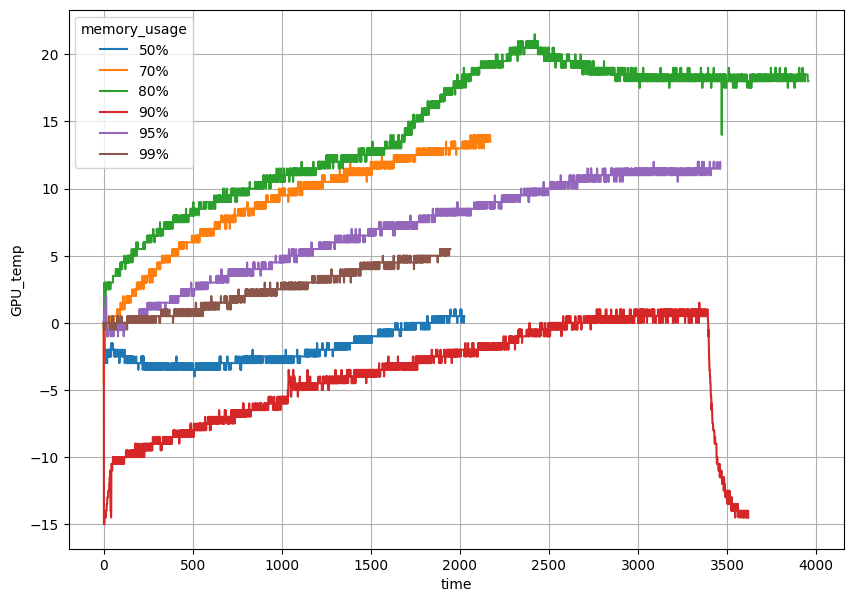

In [40]:
df["GPU_temp"] = df["temperature_GPU_temp"] - df.groupby("memory_usage")["temperature_GPU_temp"].transform("first")
fig, ax = plt.subplots(1,1,figsize=(10,7))
hue_order = ['50%', '70%', '80%', '90%', '95%', '99%']
ax.grid()
sns.lineplot(data=df, x='time', y='GPU_temp', hue='memory_usage', ax = ax, hue_order=hue_order)

## Find the correlation between the features, 

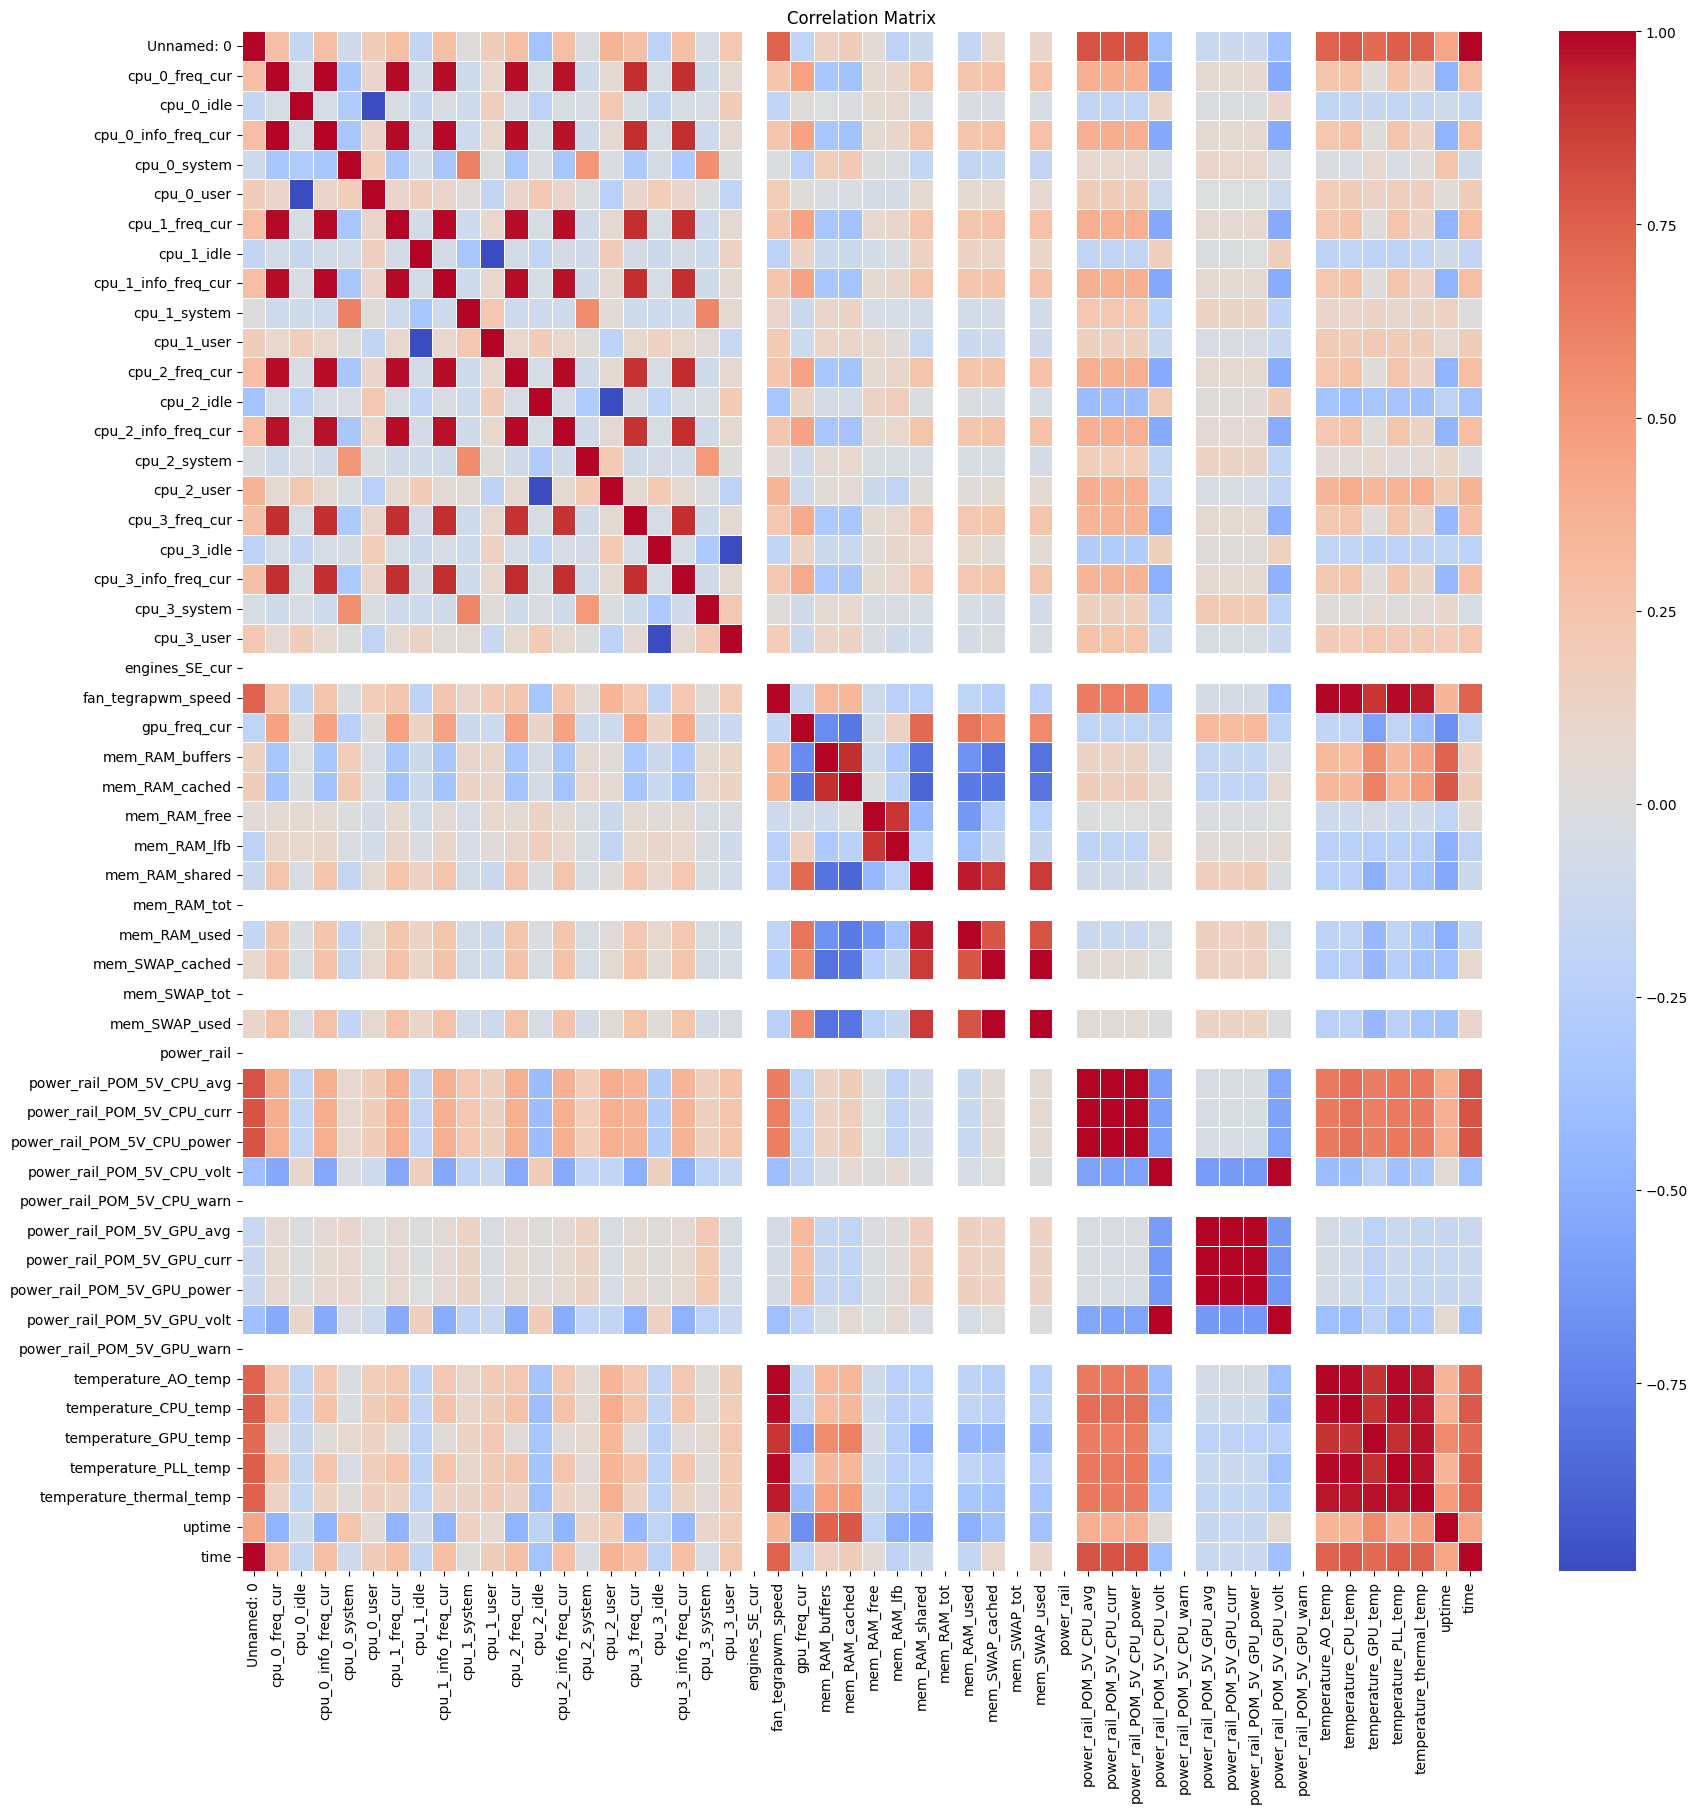

In [17]:
# Plot the heatmap
df_numeric = df.select_dtypes(include="number")
df_numeric = df_numeric.drop(columns=df_numeric.filter(like="process").columns)
df_numeric = df_numeric.drop(columns=[col for col in df_numeric.columns if "status" in col or 'state' in col or 'min' in col or 'max' in col or 'nice' in col or 'EMC' in col or 'IRAM' in col or 'rpm' in col or 'crit' in col])
plt.figure(figsize=(20, 20))  # Set figure 'size' 
sns.heatmap(df_numeric.corr(), cmap="coolwarm", fmt=".2f", linewidths=0.5)

# Show the plot
plt.title("Correlation Matrix")
plt.show()

## Maybe use a random forest regressor to gather the feature importance 